In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10
num_classes = 62

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.EMNIST(
    root='./data', split='balanced', train=True, transform=transform, download=True
)
test_dataset = datasets.EMNIST(
    root='./data', split='balanced', train=False, transform=transform, download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 561753746/561753746 [00:58<00:00, 9591213.09it/s] 


Extracting ./data\EMNIST\raw\gzip.zip to ./data\EMNIST\raw


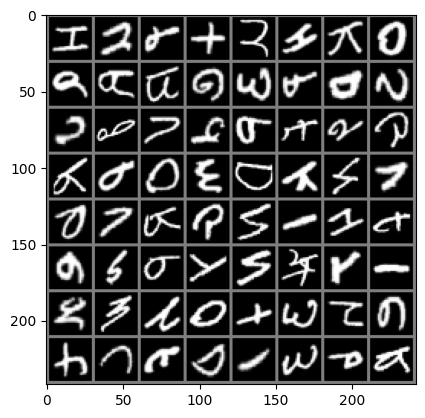

17 30 25 46 30 17 20 0 36 27 11 12 3 25 13 28 19 41 31 38 25 15 41 16 27 25 0 22 13 20 23 31 37 31 27 16 23 1 4 40 39 23 25 34 23 17 29 18 43 32 42 0 46 3 42 39 46 12 15 13 21 3 37 27


In [7]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

In [8]:
class CAPTCHAClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CAPTCHAClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.bn3(self.conv3(x)))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(-1, 128 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CAPTCHAClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss/len(train_loader))
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

train(model, train_loader, criterion, optimizer, num_epochs)

Exception ignored in: <function tqdm.__del__ at 0x0000017A44B42480>
Traceback (most recent call last):
  File "C:\Users\mitya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "C:\Users\mitya\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)


In [ ]:
torch.save(model.state_dict(), 'captcha_classifier.pth')

In [ ]:
model = CAPTCHAClassifier(num_classes=num_classes)
model.load_state_dict(torch.load('model.ipynb'))
model.to(device)